#### 关键改动:

1. 计算 scale_pos_weight: 在步骤 1 数据加载和对齐完成后，计算了 scale_pos_weight_value。
2. 添加到 cb_params 和 xgb_params: 将计算得到的 scale_pos_weight_value 添加到了 CatBoost 和 XGBoost 的参数字典中。
3. 训练时自动应用: 在 K-Fold 循环中初始化 CatBoostClassifier 和 XGBClassifier 时，它们会自动从参数字典中读取并使用 scale_pos_weight。

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For potentially saving/loading models/preprocessors

# --- Sklearn ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- Model Libraries ---
import catboost
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, logging as hf_logging, EarlyStoppingCallback
import lightgbm as lgb # Import LightGBM for Meta-Model

In [2]:
# --- Configuration ---
# Paths
data_path_cleaned = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv' # For CatBoost, XGBoost
data_path_lm = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv' # For BERT
output_dir = 'stacking_outputs_balanced' # Changed output dir name
os.makedirs(output_dir, exist_ok=True)

# Split & CV Params
test_size = 0.2
n_splits = 5 # Number of folds for K-Fold CV
random_state = 42

# Target Column
target_column = 'sentiment'
composite_key_cols = ['user_id', 'publish_time', 'game_name']

# Base Model Params (Fixed params)
# CatBoost
cb_params = {
    'iterations': 1000, 'learning_rate': 0.1, 'depth': 8,
    'loss_function': 'Logloss', 'eval_metric': 'Accuracy', # Can keep Accuracy for eval metric
    'task_type': "GPU", 'devices': '0', 'random_seed': random_state,
    'verbose': 0,
    'early_stopping_rounds': 50,
    'text_features': ['review_content_cleaned'], # Use renamed column
    'cat_features': ['game_name']
    # scale_pos_weight will be added later
}
# XGBoost
xgb_params = {
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'use_label_encoder': False, 'n_estimators': 1200,
    'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.8,
    'colsample_bytree': 0.8, 'random_state': random_state,
    'early_stopping_rounds': 50, 'tree_method': 'hist', 'device': 'cuda'
    # scale_pos_weight will be added later
}
# BERT
bert_model_name = "bert-base-chinese"
bert_train_args = TrainingArguments(
    output_dir=os.path.join(output_dir, 'bert_temp'), # Simple temp dir
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3, # Fixed epochs
    eval_strategy="no", # No eval needed during OOF training
    save_strategy="no",
    logging_steps=9999, # Suppress logging
    fp16=True,
    dataloader_pin_memory=True,
    report_to="none",
)

# Disable excessive logging from transformers
hf_logging.set_verbosity_error()

# --- GPU Check ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device == torch.device("cpu"):
    print("警告: 未检测到兼容 CUDA 的 GPU。训练会非常慢。")
    cb_params['task_type'] = 'CPU'
    if 'devices' in cb_params: del cb_params['devices']
    xgb_params['device'] = 'cpu'
    bert_train_args.fp16 = False

Using device: cuda


In [3]:
# --- 1. Load Data and Align (Using Composite Key) ---
print("加载数据并使用复合键对齐...")
try:
    # Load raw data
    df_cleaned_raw = pd.read_csv(data_path_cleaned)
    df_lm_raw = pd.read_csv(data_path_lm)

    # Define columns needed
    cb_xgb_only_feature_cols = ['review_content', 'likes']
    bert_only_feature_cols = ['review_content']
    target_col_list = [target_column]
    needed_cols_cleaned = list(set(composite_key_cols + cb_xgb_only_feature_cols + target_col_list + ['game_name']))
    needed_cols_lm = list(set(composite_key_cols + bert_only_feature_cols + target_col_list))

    df_cleaned_raw = df_cleaned_raw[needed_cols_cleaned]
    df_lm_raw = df_lm_raw[needed_cols_lm]

    # Ensure Key Column Types are Consistent
    try:
        df_cleaned_raw['publish_time'] = pd.to_datetime(df_cleaned_raw['publish_time'], errors='coerce')
        df_lm_raw['publish_time'] = pd.to_datetime(df_lm_raw['publish_time'], errors='coerce')
        df_cleaned_raw.dropna(subset=['publish_time'], inplace=True)
        df_lm_raw.dropna(subset=['publish_time'], inplace=True)
    except Exception as e:
        print(f"警告：转换 'publish_time' 为 datetime 时出错: {e}. 可能影响合并。")
    for col in ['user_id', 'game_name']:
        if col in df_cleaned_raw.columns: df_cleaned_raw[col] = df_cleaned_raw[col].astype(str)
        if col in df_lm_raw.columns: df_lm_raw[col] = df_lm_raw[col].astype(str)

    # Clean df_cleaned
    df_cleaned_processed = df_cleaned_raw.copy()
    df_cleaned_processed['review_content'] = df_cleaned_processed['review_content'].fillna('')
    if 'game_name' in df_cleaned_processed.columns: df_cleaned_processed['game_name'] = df_cleaned_processed['game_name'].fillna('Unknown')
    df_cleaned_processed.dropna(subset=['likes', target_column], inplace=True)
    df_cleaned_processed[target_column] = df_cleaned_processed[target_column].astype(int)
    df_cleaned_processed = df_cleaned_processed.drop_duplicates(subset=composite_key_cols, keep='first')

    # Clean df_lm
    df_lm_processed = df_lm_raw.copy()
    df_lm_processed.dropna(subset=['review_content', target_column], inplace=True)
    df_lm_processed[target_column] = df_lm_processed[target_column].astype(int)
    df_lm_processed = df_lm_processed.drop_duplicates(subset=composite_key_cols, keep='first')

    # Merge to Align based on Composite Key
    cols_to_merge_cleaned = list(set(composite_key_cols + cb_xgb_only_feature_cols + target_col_list + ['game_name']))
    cols_to_merge_lm = list(set(composite_key_cols + bert_only_feature_cols))
    df_cleaned_to_merge = df_cleaned_processed[cols_to_merge_cleaned].rename(columns={'review_content': 'review_content_cleaned'})
    df_lm_to_merge = df_lm_processed[cols_to_merge_lm].rename(columns={'review_content': 'review_content_lm'})
    df_aligned = pd.merge(df_cleaned_to_merge, df_lm_to_merge, on=composite_key_cols, how='inner')

    if len(df_aligned) == 0: raise ValueError("数据对齐后没有剩余样本。")
    df_aligned = df_aligned.reset_index(drop=True)
    df_aligned['review_id'] = df_aligned.index
    df_aligned = df_aligned.set_index('review_id', drop=False)
    print(f"数据对齐完成。最终样本数: {len(df_aligned)}")

    y = df_aligned[target_column]
    n_classes = y.nunique()

    # --- !!! Calculate scale_pos_weight !!! ---
    neg_count = (y == 0).sum()
    pos_count = (y == 1).sum()
    if pos_count > 0: # Avoid division by zero
        scale_pos_weight_value = neg_count / pos_count
        print(f"计算得到的 scale_pos_weight: {scale_pos_weight_value:.4f} (负样本数: {neg_count}, 正样本数: {pos_count})")
        # Add to model params
        cb_params['scale_pos_weight'] = scale_pos_weight_value
        xgb_params['scale_pos_weight'] = scale_pos_weight_value
    else:
        print("警告: 正样本数为 0，无法计算 scale_pos_weight。")


except FileNotFoundError as e: print(f"错误: 文件未找到 - {e}"); exit()
except KeyError as e: print(f"错误: 缺少必要的列 - {e}."); exit()
except Exception as e: print(f"加载或预处理数据时发生错误: {e}"); exit()

加载数据并使用复合键对齐...
数据对齐完成。最终样本数: 39985
计算得到的 scale_pos_weight: 0.5173 (负样本数: 13632, 正样本数: 26353)


In [4]:
# --- 2. Initial Train/Test Split ---
train_ids, test_ids, y_train_orig, y_test_final = train_test_split(
    df_aligned['review_id'].values, y.values, test_size=test_size,
    random_state=random_state, stratify=y
)
print(f"初始划分: 训练集 {len(train_ids)} 样本 (IDs), 测试集 {len(test_ids)} 样本 (IDs)")

初始划分: 训练集 31988 样本 (IDs), 测试集 7997 样本 (IDs)


In [5]:
# --- 3. Define Base Model Training/Prediction Functions ---

# == XGBoost Preprocessor ==
xgb_text_col = 'review_content_cleaned'
xgb_cat_cols = ['game_name']
xgb_num_cols = ['likes']
xgb_input_cols = [xgb_text_col] + xgb_cat_cols + xgb_num_cols

xgb_text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000, stop_words=None))])
xgb_cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])
xgb_num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('text', xgb_text_transformer, xgb_text_col),
        ('cat', xgb_cat_transformer, xgb_cat_cols),
        ('num', xgb_num_transformer, xgb_num_cols)
    ],
    remainder='passthrough',
    sparse_threshold=0.3
)

# == BERT Dataset ==
class SentimentDataset(Dataset):
    # (Dataset class remains the same)
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts; self.labels = labels; self.tokenizer = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        text = str(self.texts[idx]); label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',
        )
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'labels': torch.tensor(label, dtype=torch.long)}
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [6]:
# --- 4. Generate OOF and Test Predictions ---
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

oof_preds_catboost = np.zeros((len(train_ids), n_classes))
oof_preds_xgb = np.zeros((len(train_ids), n_classes))
oof_preds_bert = np.zeros((len(train_ids), n_classes))

test_preds_catboost = np.zeros((len(test_ids), n_classes))
test_preds_xgb = np.zeros((len(test_ids), n_classes))
test_preds_bert = np.zeros((len(test_ids), n_classes))

# Store final fitted models
final_models_catboost = []
final_models_xgb_pipe = []
final_models_bert = []


print(f"\n开始 {n_splits}-折交叉验证生成 OOF 预测 (已应用类别平衡)...")

for fold, (train_fold_local_idx, val_fold_local_idx) in enumerate(kf.split(np.zeros(len(train_ids)), y_train_orig)):
    print(f"--- Fold {fold+1}/{n_splits} ---")
    fold_start_time = time.time()

    # --- Get data for this fold ---
    train_fold_ids = train_ids[train_fold_local_idx]
    val_fold_ids = train_ids[val_fold_local_idx]
    X_train_fold_aligned = df_aligned.loc[train_fold_ids]
    y_train_fold = y.loc[train_fold_ids]
    X_val_fold_aligned = df_aligned.loc[val_fold_ids]
    y_val_fold = y.loc[val_fold_ids]

    # --- Train CatBoost ---
    print(f"  训练 CatBoost...")
    # Define feature indices for CatBoost Pool
    cb_feature_names = ['review_content_cleaned', 'game_name', 'likes']
    cat_features_indices = [i for i, col in enumerate(cb_feature_names) if col == 'game_name']
    text_features_indices = [i for i, col in enumerate(cb_feature_names) if col == 'review_content_cleaned']

    # Use Pool objects
    train_pool = Pool(data=X_train_fold_aligned[cb_feature_names], label=y_train_fold,
                      cat_features=cat_features_indices,
                      text_features=text_features_indices)
    val_pool = Pool(data=X_val_fold_aligned[cb_feature_names], label=y_val_fold,
                    cat_features=cat_features_indices,
                    text_features=text_features_indices)

    # Initialize model with params (including scale_pos_weight if calculated)
    cb_model = CatBoostClassifier(**cb_params)
    cb_model.fit(train_pool, eval_set=val_pool, verbose=0) # Use early stopping from params
    oof_preds_catboost[val_fold_local_idx] = cb_model.predict_proba(val_pool)
    final_models_catboost.append(cb_model)
    print(f"  CatBoost 训练完成。")


    # --- Train XGBoost ---
    print(f"  训练 XGBoost...")
    # Initialize pipeline with params (including scale_pos_weight if calculated)
    xgb_pipe_fold = Pipeline(steps=[('preprocessor', xgb_preprocessor),
                                    ('classifier', xgb.XGBClassifier(**xgb_params))])
    # Fit preprocessor
    xgb_preprocessor_fitted = xgb_pipe_fold.named_steps['preprocessor'].fit(X_train_fold_aligned[xgb_input_cols])
    # Transform data
    X_train_processed = xgb_preprocessor_fitted.transform(X_train_fold_aligned[xgb_input_cols])
    X_val_processed = xgb_preprocessor_fitted.transform(X_val_fold_aligned[xgb_input_cols])
    # Fit classifier with early stopping
    xgb_pipe_fold.named_steps['classifier'].fit(X_train_processed, y_train_fold,
                                                eval_set=[(X_val_processed, y_val_fold)],
                                                verbose=False)
    # Predict OOF using the pipeline
    oof_preds_xgb[val_fold_local_idx] = xgb_pipe_fold.predict_proba(X_val_fold_aligned[xgb_input_cols])
    final_models_xgb_pipe.append(xgb_pipe_fold)
    print(f"  XGBoost 训练完成。")


    # --- Train BERT ---
    print(f"  训练 BERT...")
    bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=n_classes)
    bert_model.to(device)
    X_train_fold_lm_texts = X_train_fold_aligned['review_content_lm'].tolist()
    y_train_fold_list = y_train_fold.tolist()
    X_val_fold_lm_texts = X_val_fold_aligned['review_content_lm'].tolist()
    y_val_fold_list = y_val_fold.tolist()

    train_fold_dataset = SentimentDataset(X_train_fold_lm_texts, y_train_fold_list, bert_tokenizer)
    # No need for eval dataset here since evaluation_strategy="no"
    trainer = Trainer(model=bert_model, args=bert_train_args, train_dataset=train_fold_dataset)
    trainer.train()

    # Predict on validation fold
    val_fold_dataset = SentimentDataset(X_val_fold_lm_texts, y_val_fold_list, bert_tokenizer)
    val_predictions = trainer.predict(val_fold_dataset)
    oof_preds_bert[val_fold_local_idx] = torch.softmax(torch.tensor(val_predictions.predictions), dim=-1).cpu().numpy()
    final_models_bert.append(trainer.model) # Store the trained model
    print(f"  BERT 训练完成。")

    fold_end_time = time.time()
    print(f"--- Fold {fold+1} 完成, 耗时: {fold_end_time - fold_start_time:.2f} 秒 ---")
    if torch.cuda.is_available(): torch.cuda.empty_cache()


print(f"\nOOF 预测生成完毕。")

# --- Generate Test Predictions using final models ---
print("\n使用 K-Fold 模型平均生成测试集预测...")
X_test_aligned = df_aligned.loc[test_ids]
y_test_final = y.loc[test_ids]

# Average CatBoost predictions
cb_features_test = X_test_aligned[['review_content_cleaned', 'game_name', 'likes']]
test_pool_final = Pool(data=cb_features_test, cat_features=cat_features_indices, text_features=text_features_indices)
test_preds_catboost_all_folds = np.array([model.predict_proba(test_pool_final) for model in final_models_catboost])
test_preds_catboost = np.mean(test_preds_catboost_all_folds, axis=0)

# Average XGBoost predictions
test_preds_xgb_all_folds = np.array([pipe.predict_proba(X_test_aligned[xgb_input_cols]) for pipe in final_models_xgb_pipe])
test_preds_xgb = np.mean(test_preds_xgb_all_folds, axis=0)

# Average BERT predictions
X_test_lm_texts = X_test_aligned['review_content_lm'].tolist()
test_dataset_final = SentimentDataset(X_test_lm_texts, y_test_final.tolist(), bert_tokenizer)
test_preds_bert_all_folds = []
dummy_args = TrainingArguments(output_dir=os.path.join(output_dir, 'bert_dummy'), report_to="none", per_device_eval_batch_size=64, fp16=bert_train_args.fp16)
for model in final_models_bert:
    model.eval()
    model.to(device)
    dummy_trainer = Trainer(model=model, args=dummy_args)
    with torch.no_grad():
        predictions = dummy_trainer.predict(test_dataset_final)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).cpu().numpy()
    test_preds_bert_all_folds.append(probs)
test_preds_bert = np.mean(np.array(test_preds_bert_all_folds), axis=0)

print("测试集预测生成完毕。")


开始 5-折交叉验证生成 OOF 预测 (已应用类别平衡)...
--- Fold 1/5 ---
  训练 CatBoost...
  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:32:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\core.py:729: UserWarning: [22:32:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss


  BERT 训练完成。
--- Fold 1 完成, 耗时: 440.57 秒 ---
--- Fold 2/5 ---
  训练 CatBoost...
  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:39:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss


  BERT 训练完成。
--- Fold 2 完成, 耗时: 429.02 秒 ---
--- Fold 3/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:46:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss


  BERT 训练完成。
--- Fold 3 完成, 耗时: 424.85 秒 ---
--- Fold 4/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:53:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss


  BERT 训练完成。
--- Fold 4 完成, 耗时: 413.76 秒 ---
--- Fold 5/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:00:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss


  BERT 训练完成。
--- Fold 5 完成, 耗时: 435.49 秒 ---

OOF 预测生成完毕。

使用 K-Fold 模型平均生成测试集预测...
测试集预测生成完毕。


In [7]:
# --- 5. Prepare Meta-Model Input ---
print("\n准备 Meta-Model 输入...")
X_meta_train = np.concatenate([oof_preds_catboost, oof_preds_xgb, oof_preds_bert], axis=1)
X_meta_test = np.concatenate([test_preds_catboost, test_preds_xgb, test_preds_bert], axis=1)
print(f"Meta Train 特征维度: {X_meta_train.shape}")
print(f"Meta Test 特征维度: {X_meta_test.shape}")


准备 Meta-Model 输入...
Meta Train 特征维度: (31988, 6)
Meta Test 特征维度: (7997, 6)


In [33]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform # For defining parameter distributions

# --- 替换步骤 6 ---
print("\n训练 Meta-Model (Logistic Regression with GridSearchCV for C)...")
# 定义参数网格
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
# 使用 StratifiedKFold 进行内部交叉验证以选择 C
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
# 初始化 Logistic Regression
lr_meta = LogisticRegression(random_state=random_state, max_iter=2000, solver='liblinear') # solver='liblinear' 对 L1/L2 都适用

# 设置 GridSearchCV
meta_model_search = GridSearchCV(estimator=lr_meta,
                                 param_grid=param_grid,
                                 cv=inner_cv,
                                 scoring='accuracy', # 或 'f1_weighted' 等
                                 refit=True, # 用最佳参数在整个 X_meta_train 上重新训练
                                 verbose=1) # 显示搜索过程

# 在 OOF 预测和原始训练标签上进行搜索和训练
meta_model_search.fit(X_meta_train, y_train_orig)

print(f"Meta-Model 最佳参数 (C): {meta_model_search.best_params_}")
print(f"Meta-Model 最佳 CV 分数: {meta_model_search.best_score_:.4f}")
# 最优模型存储在 meta_model_search.best_estimator_
meta_model = meta_model_search.best_estimator_ # 使用找到的最佳模型
print("Meta-Model 训练完成。")


训练 Meta-Model (Logistic Regression with GridSearchCV for C)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meta-Model 最佳参数 (C): {'C': 1}
Meta-Model 最佳 CV 分数: 0.8621
Meta-Model 训练完成。


In [34]:
# --- 7. Final Prediction with Meta-Model ---
print("\n使用 Meta-Model 在测试集上进行最终预测...")
final_predictions = meta_model.predict(X_meta_test)
final_probabilities = meta_model.predict_proba(X_meta_test)


使用 Meta-Model 在测试集上进行最终预测...



--- Stacking 集成模型最终评估 (已应用类别平衡) ---
分类报告:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2726
           1       0.87      0.91      0.89      5271

    accuracy                           0.86      7997
   macro avg       0.85      0.83      0.84      7997
weighted avg       0.85      0.86      0.85      7997


最终准确率: 0.8559

混淆矩阵:
[[2028  698]
 [ 454 4817]]


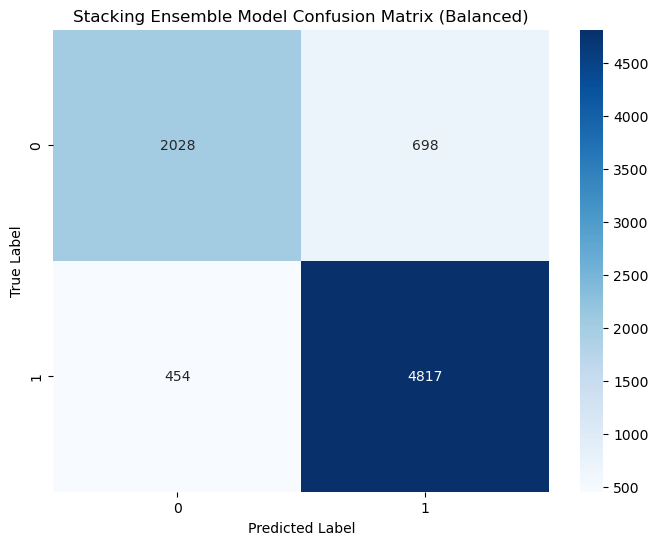


Stacking 脚本执行完毕。


In [35]:
# --- 8. Evaluate Final Stacked Model ---
print("\n--- Stacking 集成模型最终评估 (已应用类别平衡) ---")
# (Evaluation code remains the same)
print("分类报告:")
try:
    target_names = [str(c) for c in sorted(np.unique(y_test_final))]
    print(classification_report(y_test_final, final_predictions, target_names=target_names))
except Exception as e:
    print(f"生成分类报告时出错: {e}")
    print(classification_report(y_test_final, final_predictions))
accuracy = accuracy_score(y_test_final, final_predictions)
print(f"\n最终准确率: {accuracy:.4f}")
print("\n混淆矩阵:")
cm = confusion_matrix(y_test_final, final_predictions)
print(cm)
try:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Stacking Ensemble Model Confusion Matrix (Balanced)')
    plt.show()
except NameError: print("\n无法绘制混淆矩阵，可能缺少 target_names。")
except Exception as e: print(f"\n绘制混淆矩阵时出错: {e}")

print("\nStacking 脚本执行完毕。")

# Optional: Clean up BERT temp directories
# import shutil
# shutil.rmtree(os.path.join(output_dir, 'bert_temp'), ignore_errors=True)
# shutil.rmtree(os.path.join(output_dir, 'bert_dummy'), ignore_errors=True)